In [17]:
import matplotlib.pyplot as plt
import numpy as np
from gibbs_u import FactorCopulaGibbs
from scipy.stats import norm, t as student_t
import particles
from particles import state_space_models as ssm
from particles import distributions as dists
from particles import mcmc
from numba import njit

In [ ]:
def simulate_factor_copula(T=200, n=10, p=1, mu=0.5, phi=0.95, sigma=0.1, 
                           copula_type='gaussian', nu=5.0, seed=67):
    
    np.random.seed(seed)
    
    # Loadings (AR1)
    lambdas = np.zeros((T, n, p))
    var_stat = sigma**2 / (1 - phi**2)
    lambdas[0] = np.random.normal(mu, np.sqrt(var_stat), size=(n, p))
    
    for t in range(1, T):
        lambdas[t] = mu + phi * (lambdas[t-1] - mu) + np.random.normal(0, sigma, size=(n, p))
    
    # Contrainte diagonale positive
    for i in range(min(n, p)):
        lambdas[:, i, i] = np.abs(lambdas[:, i, i])
    
    # Facteurs
    z = np.random.normal(0, 1, size=(T, p))
    
    # Génération des x_t
    x_data = np.zeros((T, n))
    zeta = np.ones(T)
    
    for t in range(T):
        lam_t = lambdas[t]
        lam_sq = np.sum(lam_t**2, axis=1)
        sigma_eps = np.sqrt(1.0 / (1.0 + lam_sq))
        lam_tilde = lam_t / np.sqrt(1 + lam_sq)[:, np.newaxis]
        
        if copula_type == 'student':
            zeta[t] = 1.0 / np.random.gamma(nu/2, 2.0/nu)
            z_tilde = np.random.normal(0, 1, size=p)
            eps = np.random.normal(0, 1, size=n)
            x_data[t] = np.sqrt(zeta[t]) * (lam_tilde @ z_tilde + sigma_eps * eps)
        else:
            x_data[t] = lam_tilde @ z[t] + sigma_eps * np.random.normal(0, 1, size=n)
    
    # Transformation en uniformes
    if copula_type == 'student':
        u_data = student_t.cdf(x_data, df=nu)
    else:
        u_data = norm.cdf(x_data)
    
    return u_data, {
        'mu': mu, 'phi': phi, 'sigma': sigma, 'nu': nu if copula_type == 'student' else None
    }, {
        'lambdas': lambdas, 'z': z, 'zeta': zeta if copula_type == 'student' else None
    }

In [19]:
T_sim, n_series_sim = 300, 5
true_nu = 5.0
true_phi = 0.95

print(f"Génération de {T_sim} points pour {n_series_sim} actifs...")
u_data, true_params, true_states = simulate_factor_copula(
    T=T_sim, n=n_series_sim, p=1, 
    mu=0.6, phi=true_phi, sigma=0.1, 
    copula_type='student', nu=true_nu
)

n_iterations = 2000
n_particles_gibbs = 1000

print("\nLancement du Gibbs Sampler...")
sampler = FactorCopulaGibbs(
    u_data=u_data, 
    n_factors=1, 
    copula_type='student', 
    nu_init=12.0
)

# Exécution
sampler.run(n_iter=n_iterations, n_particles=n_particles_gibbs)

Génération de 300 points pour 5 actifs...

Lancement du Gibbs Sampler...


100%|██████████| 2000/2000 [04:36<00:00,  7.24it/s]


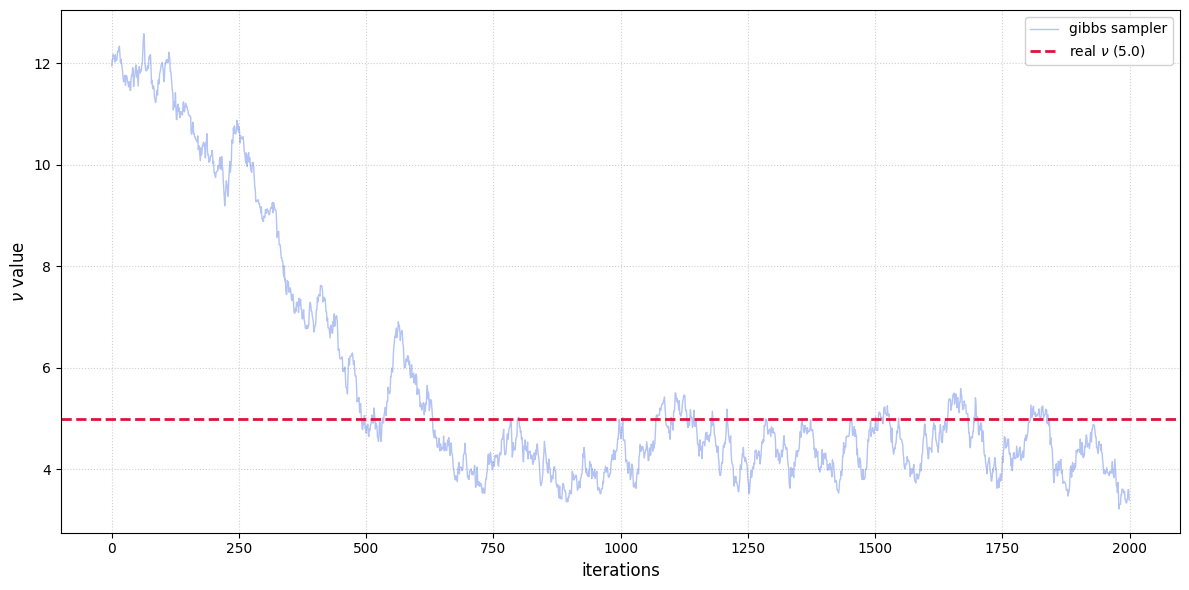

In [ ]:
# Plot
trace_nu = np.array(sampler.trace['nu'])

plt.figure(figsize=(12, 6))
ax = plt.gca()
iterations = np.arange(len(trace_nu))

ax.plot(iterations, trace_nu, color='royalblue', alpha=0.4, lw=1, label='gibbs sampler')
ax.axhline(true_nu, color='crimson', linestyle='--', lw=2, label=f'real $\\nu$ ({true_nu})')

ax.set_xlabel("iterations", fontsize=12)
ax.set_ylabel("$\\nu$ value", fontsize=12)
ax.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)
ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()